# From PDF to GTFS - Demo for Aveiro Bus line 11

This notebook demonstrates how to create a GTFS Schedule feed for Aveiro Bus line 11. The main source of data is the line's PDF file with the complete schedule. Its information is complemented with data from the STePP database, namely to search the location of some stops.

> The PDF file is used by the Aveiro Bus operator to communicate the most up-to-date schedule. It is the most reliable source of information for the schedule of line 11 available to the public.

> The most recent version of the STePP database from Aveiro Bus available to the public is old (released in 2023, but refers to 2017). ALthough some stop names are slightly different, stops were possible to match automatically between the PDF file and the STePP database based on similarity scores. However, 3 missing stops (newer) had to be added manually.

To assist in the process, wrapper classes for the STePP database (`SteppWrapper`) and the PDF file (`PdfWrapper`) were created, as well as data classes to represent the required GTFS entities (`agency.txt`, `routes.txt`, `trips.txt`, `stops.txt`, `stop_times.txt`, `calendar.txt`, `calendar_dates.txt`). In the end, the GTFS feed is validated using the Canonical GTFS Feed Validator.

The main steps in this demonstration are as follows:

1. Extract data from STePP database (from Aveiro Bus operator).
2. Extract data from PDF file (schedule for line 11).
3. Create required entities for a valid GTFS Schedule feed (using STePP and PDF data).
4. Validate the GTFS feed using the Canonical GTFS Feed Validator.

In [1]:
import os
import re
import zipfile

from datetime import datetime, timedelta
from rapidfuzz import process, fuzz
from wrappers import PdfWrapper, SteppWrapper

from gtfs import (
    GtfsAgency,
    GtfsCalendarDate,
    GtfsCalendar,
    GtfsCsvWriter,
    GtfsRoute,
    GtfsStopTime,
    GtfsStop,
    GtfsTrip,
)
from gtfs import (
    GtfsExceptionType,
    GtfsServiceAvailability,
    GtfsRouteType,
    GtfsLocationType,
)

## 1. Extract data from STePP database (from Aveiro Bus operator)

In [2]:
stepp_wrapper = SteppWrapper(file_path='../resources/aveiro-bus.stepp.zip')
stepp_data = stepp_wrapper.get_data()

print(f'{"Table":<15} {"Cols":<5} {"Rows":<5} {"Type":<50}')
print(f'{"-" * 15} {"-" * 5} {"-" * 5} {"-" * 50}')
for k, v in stepp_data.items():
    print(f'{k:<15} {len(v.columns):<5} {len(v):<5} {str(type(v)):<50}')

Table           Cols  Rows  Type                                              
--------------- ----- ----- --------------------------------------------------
circulacoes     13    1954  <class 'pandas.core.frame.DataFrame'>             
paragens        24    9005  <class 'geopandas.geodataframe.GeoDataFrame'>     
segmentos       17    8548  <class 'geopandas.geodataframe.GeoDataFrame'>     
servicos        41    264   <class 'pandas.core.frame.DataFrame'>             


## 2. Extract data from PDF file (schedule for line 11).

In [3]:
pdf_wrapper = PdfWrapper(file_path='../resources/aveiro-bus-11.pdf')

Name of the route (`pdf_route_name`)

In [4]:
page_index = 0
page_rotation = 0
bbox = {
    'left': 40,
    'top': 40,
    'right': 40,
    'bottom': 250,
}
bbox_units = 'mm'
table_settings = {
    'horizontal_strategy': 'text',
    'vertical_strategy': 'text',
    'min_words_vertical': 1,
}
pdf_wrapper.debug_table_detection(
    page_index=page_index,
    page_rotation=page_rotation,
    bbox=bbox,
    bbox_units=bbox_units,
    table_settings=table_settings,
)

In [5]:
pdf_route_name = pdf_wrapper.get_tables(
    page_index=page_index,
    page_rotation=page_rotation,
    bbox=bbox,
    bbox_units=bbox_units,
    table_settings=table_settings,
)
for table in pdf_route_name:
    print(table)

[['AVEIRO', 'ESTAÇÃO', '|', 'AVEIRO', '(UA)']]


### Timetable schedules (`pdf_schedules`)

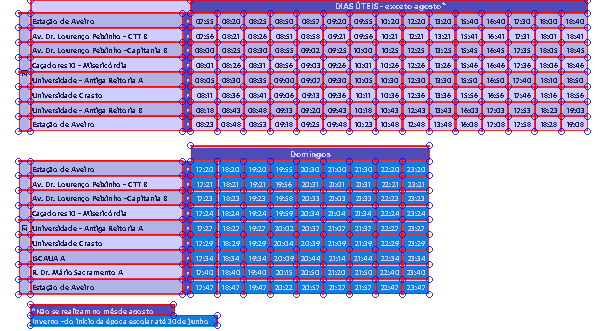

In [6]:
page_index = 0
page_rotation = 0
bbox = {
    'left': 40,
    'top': 50,
    'right': 40,
    'bottom': 130,
}
bbox_units = 'mm'
table_settings = {
    'horizontal_strategy': 'lines',
    'vertical_strategy': 'lines',
    'intersection_x_tolerance': 1_000,
    'intersection_y_tolerance': 10,
    'snap_tolerance': 5,
}
pdf_wrapper.debug_table_detection(
    page_index=page_index,
    page_rotation=page_rotation,
    bbox=bbox,
    bbox_units=bbox_units,
    table_settings=table_settings,
)

In [7]:
pdf_schedules = pdf_wrapper.get_tables(
    page_index=page_index,
    page_rotation=page_rotation,
    bbox=bbox,
    bbox_units=bbox_units,
    table_settings=table_settings,
)
for table in pdf_schedules:
    print(table)

[[None, '', None, 'DIAS ÚTEIS - exceto agosto*', None, None, None, None, None, None, None, None, None, None, None, None, None, None], ['', 'Estação de Aveiro', '▼', '07:55', '08:20', '08:25', '08:50', '08:57', '09:20', '09:55', '10:20', '12:20', '13:20', '15:40', '16:40', '17:30', '18:00', '18:40'], ['', 'Av. Dr. Lourenço Peixinho - CTT B', '▼', '07:56', '08:21', '08:26', '08:51', '08:58', '09:21', '09:56', '10:21', '12:21', '13:21', '15:41', '16:41', '17:31', '18:01', '18:41'], ['', 'Av. Dr. Lourenço Peixinho - Capitania B', '▼', '08:00', '08:25', '08:30', '08:55', '09:02', '09:25', '10:00', '10:25', '12:25', '13:25', '15:45', '16:45', '17:35', '18:05', '18:45'], ['1', 'Caçadores 10 - Misericórdia', '▼', '08:01', '08:26', '08:31', '08:56', '09:03', '09:26', '10:01', '10:26', '12:26', '13:26', '15:46', '16:46', '17:36', '18:06', '18:46'], ['Z', 'Universidade - Antiga Reitoria A', '▼', '08:05', '08:30', '08:35', '09:00', '09:07', '09:30', '10:05', '10:30', '12:30', '13:30', '15:50', '16

### Covered stops (`pdf_stops`)

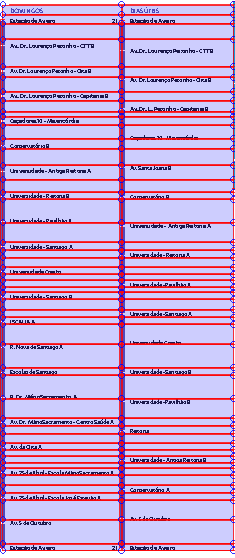

In [8]:
page_index = 0
page_rotation = 90
bbox = {
    'left': 50,
    'top': 50,
    'right': 164,
    'bottom': 50,
}
bbox_units = 'mm'
table_settings = {
    'horizontal_strategy': 'text',
    'vertical_strategy': 'lines',
    'intersection_x_tolerance': 100,
    'intersection_y_tolerance': 1_000,
    'snap_tolerance': 5,
}
pdf_wrapper.debug_table_detection(
    page_index=page_index,
    page_rotation=page_rotation,
    bbox=bbox,
    bbox_units=bbox_units,
    table_settings=table_settings,
)

In [9]:
pdf_stops = pdf_wrapper.get_tables(
    page_index=page_index,
    page_rotation=page_rotation,
    bbox=bbox,
    bbox_units=bbox_units,
    table_settings=table_settings,
)
for table in pdf_stops:
    print(table)

[['DOMINGOS', 'DIAS ÚTEIS'], ['Estação de Aveiro Z1', 'Estação de Aveiro'], ['', ''], ['Av. Dr. Lourenço Peixinho - CTT B', 'Av. Dr. Lourenço Peixinho - CTT B'], ['Av. Dr. Lourenço Peixinho - Oita B', ''], ['', 'Av. Dr. Lourenço Peixinho - Oita B'], ['Av. Dr. Lourenço Peixinho - Capitania B', ''], ['', 'Av. Dr. L. Peixinho - Capitania B'], ['', ''], ['Caçadores 10 - Misericórdia', ''], ['', 'Caçadores 10 - Misericórdia'], ['Conservatório B', ''], ['', ''], ['Universidade - Antiga Reitoria A', 'Av. Santa Joana B'], ['', ''], ['Universidade - Reitoria B', 'Conservatório B'], ['Universidade - Pavilhão A', ''], ['', 'Universidade - Antiga Reitoria A'], ['Universidade - Santiago A', ''], ['', 'Universidade - Reitoria A'], ['', ''], ['Universidade Crasto', ''], ['', ''], ['', 'Universidade - Pavilhão A'], ['', ''], ['Universidade - Santiago B', ''], ['', ''], ['', 'Universidade - Santiago A'], ['ISCAUA A', ''], ['', 'Universidade Crasto'], ['R. Nova de Santiago A', ''], ['Escolas de Santiago

## 3. Create required entities for a valid GTFS Schedule feed (using STePP and PDF data).

The most basic GTFS Schedule feed is composed of 7 files:
- `agency.txt`
- `routes.txt`
- `trips.txt`
- `stops.txt`
- `stop_times.txt`
- `calendar.txt`
- `calendar_dates.txt`

The creation of the feed followed the official [GTFS Schedule Reference](https://gtfs.org/documentation/schedule/reference/).

### Construction of `agency.txt`

In [10]:
gtfs_agency = GtfsAgency(
    agency_id='AVEIRO_BUS',
    agency_name='Aveiro Bus',
    agency_url='http://www.aveirobus.pt/',
    agency_timezone='Europe/Lisbon',
    agency_lang='pt',
)
gtfs_agency

GtfsAgency(agency_id='AVEIRO_BUS', agency_name='Aveiro Bus', agency_url='http://www.aveirobus.pt/', agency_timezone='Europe/Lisbon', agency_lang='pt')

### Construction of `stops.txt`

1. Transform all stops from STePP database into GTFS stops

In [11]:
all_gtfs_stops = []
all_gtfs_stops_dict = {}

for _, stepp_stop in stepp_data['paragens'].iterrows():
    stop_lat = stepp_stop['geometry'].y
    stop_lon = stepp_stop['geometry'].x
    stop_name = stepp_stop['designacao']
    stop_id = str(hash(f'{stop_lat}{stop_lon}{stop_name}'))

    gtfs_stop = GtfsStop(
        stop_id=stop_id,
        # stop_code=None,
        stop_name=stop_name,
        stop_lat=stop_lat,
        stop_lon=stop_lon,
        # zone_id=None,
        # stop_url=None,
        location_type=GtfsLocationType.STOP,
    )
    all_gtfs_stops.append(gtfs_stop)
    all_gtfs_stops_dict[stop_name] = gtfs_stop

print('Number of stops:', len(all_gtfs_stops))
print(all_gtfs_stops_dict['Estação de Aveiro'])

Number of stops: 9005
GtfsStop(stop_id='-7978747450465050333', stop_name='Estação de Aveiro', stop_lat=40.6435094466338, stop_lon=-8.641563019256438, stop_code=None, zone_id=None, stop_url=None, location_type=<GtfsLocationType.STOP: 0>)


2. Clean stop names from PDF file

In [12]:
stop_names = set()

for sub_list in pdf_stops[0][1:]:  # Skip headers
    for stop_name in sub_list:
        if stop_name == '':
            continue
        if re.match(r'.*Z\d+.*', stop_name):  # Detect stop_name with Z\d+ pattern
            stop_name = re.sub(r'\s*Z\d+\s*', '', stop_name)  # Remove Z\d+ pattern
        stop_names.add(stop_name)

stop_names

{'Av. 25 de Abril - Escola José Estevão A',
 'Av. 25 de Abril - Escola Mário Sacramento A',
 'Av. 5 de Outubro',
 'Av. Dr. L. Peixinho - Capitania B',
 'Av. Dr. Lourenço Peixinho - CTT B',
 'Av. Dr. Lourenço Peixinho - Capitania B',
 'Av. Dr. Lourenço Peixinho - Oita B',
 'Av. Dr. Mário Sacramento - Centro Saúde A',
 'Av. Santa Joana B',
 'Av. da Oita A',
 'Caçadores 10 - Misericórdia',
 'Conservatório A',
 'Conservatório B',
 'Escolas de Santiago',
 'Estação de Aveiro',
 'ISCAUA A',
 'R. Dr. Mário Sacramento A',
 'R. Nova de Santiago A',
 'Reitoria',
 'Universidade - Antiga Reitoria A',
 'Universidade - Antiga Reitoria B',
 'Universidade - Pavilhão A',
 'Universidade - Pavilhão B',
 'Universidade - Reitoria A',
 'Universidade - Reitoria B',
 'Universidade - Santiago A',
 'Universidade - Santiago B',
 'Universidade Crasto'}

3. Find stops from PDF file that are not found in STePP database through their names

In [13]:
unmatched_stop_names = set()
for stop_name in stop_names:
    if stop_name not in all_gtfs_stops_dict.keys():
        unmatched_stop_names.add(stop_name)
unmatched_stop_names

{'Av. 25 de Abril - Escola José Estevão A',
 'Av. 25 de Abril - Escola Mário Sacramento A',
 'Av. 5 de Outubro',
 'Av. Dr. L. Peixinho - Capitania B',
 'Av. Dr. Mário Sacramento - Centro Saúde A',
 'Av. da Oita A',
 'Conservatório A',
 'Conservatório B',
 'R. Dr. Mário Sacramento A',
 'R. Nova de Santiago A',
 'Reitoria',
 'Universidade - Antiga Reitoria A',
 'Universidade - Antiga Reitoria B',
 'Universidade - Pavilhão A',
 'Universidade - Pavilhão B',
 'Universidade - Reitoria A',
 'Universidade - Reitoria B',
 'Universidade - Santiago A',
 'Universidade - Santiago B',
 'Universidade Crasto'}

4. Find stops in STePP database with similar names to unmatched stops from PDF file

In [14]:
def weighted_fuzzy_match(query, choices):
    # Get the top 5 fuzzy matches
    results = process.extract(query, choices, scorer=fuzz.token_sort_ratio, limit=5)
    
    # Prioritize exact word matches
    query_words = set(query.lower().split())

    best_match = None
    best_score = 0

    for match, score, _ in results:
        match_words = set(match.lower().split())

        # Boost score if the query word is fully contained in the match
        if query_words.issubset(match_words):
            score += 100  # Increase weight for exact word presence

        # Select the best-scoring result
        if score > best_score:
            best_score = score
            best_match = match

    return best_match, score

In [15]:
matched_stop_names_with_score = {}
print(f'{"Stop Name":<50} {"Best Match":<50} {"Score":<6}') 
print(f'{"-" * 50} {"-" * 50} {"-" * 6}')
for stop_name in unmatched_stop_names:
    if stop_name not in all_gtfs_stops_dict.keys():
        best_match, score = weighted_fuzzy_match(stop_name, all_gtfs_stops_dict.keys())
        matched_stop_names_with_score[stop_name] = best_match, score
        print(f'{stop_name:<50} {best_match:<50} {score:>6.2f} {"<" if score < 50 else ""}')

Stop Name                                          Best Match                                         Score 
-------------------------------------------------- -------------------------------------------------- ------
R. Dr. Mário Sacramento A                          Rua Dr. Mário Sacramento A                          57.14 
Universidade - Reitoria A                          Universidade - Reitoria                             73.91 
Universidade - Pavilhão B                          Universidade - Pavilhão                             70.83 
Av. da Oita A                                      Avenida da Oita A                                   50.00 
Universidade - Reitoria B                          Universidade - Reitoria                             73.91 
Conservatório A                                    Aradas - Correios                                   45.71 <
Reitoria                                           Universidade - Reitoria                            151.61 
Av. 5 de Ou

5. Exclude stops with low similarity score and manually add them

In [16]:
unmatched_stop_names = set()
for stop_name, (best_match, score) in matched_stop_names_with_score.items():
    if score < 50:
        unmatched_stop_names.add(stop_name)
        continue
    all_gtfs_stops_dict[stop_name] = all_gtfs_stops_dict[best_match]
unmatched_stop_names

{'Av. 5 de Outubro', 'Conservatório A', 'Conservatório B'}

In [17]:
for stop_data in [
    {'stop_name': 'Conservatório A', 'stop_lat': 40.6364063, 'stop_lon': -8.6543704},
    {'stop_name': 'Conservatório B', 'stop_lat': 40.636500, 'stop_lon': -8.653962},
    {'stop_name': 'Av. 5 de Outubro', 'stop_lat': 40.641892, 'stop_lon': -8.646715},
]:
    stop_id = str(
        hash(f"{stop_data['stop_lat']}{stop_data['stop_lon']}{stop_data['stop_name']}")
    )
    gtfs_stop = GtfsStop(
        stop_id=stop_id,
        stop_name=stop_data['stop_name'],
        stop_lat=stop_data['stop_lat'],
        stop_lon=stop_data['stop_lon'],
        location_type=GtfsLocationType.STOP,
    )
    all_gtfs_stops.append(gtfs_stop)
    all_gtfs_stops_dict[stop_data['stop_name']] = gtfs_stop

5. Verify that all stops from PDF file are associated with a stop from STePP database

In [18]:
all(stop_name in all_gtfs_stops_dict.keys() for stop_name in stop_names)

True

6. Remove duplicate stops after association

In [19]:
gtfs_stops = list(set([all_gtfs_stops_dict[stop_name] for stop_name in stop_names]))
gtfs_stops_dict = {gtfs_stop.stop_name: gtfs_stop for gtfs_stop in gtfs_stops}
gtfs_stops

[GtfsStop(stop_id='-7416044751956061976', stop_name='Rua Dr. Mário Sacramento - Centro de Saúde A', stop_lat=40.63186828879385, stop_lon=-8.648376613417811, stop_code=None, zone_id=None, stop_url=None, location_type=<GtfsLocationType.STOP: 0>),
 GtfsStop(stop_id='1296326338167383190', stop_name='Av. 5 de Outubro', stop_lat=40.641892, stop_lon=-8.646715, stop_code=None, zone_id=None, stop_url=None, location_type=<GtfsLocationType.STOP: 0>),
 GtfsStop(stop_id='-4437974693873153127', stop_name='Universidade - Antiga Reitoria', stop_lat=40.634505014643544, stop_lon=-8.6574848781651, stop_code=None, zone_id=None, stop_url=None, location_type=<GtfsLocationType.STOP: 0>),
 GtfsStop(stop_id='1404690494610635814', stop_name='Universidade - Reitoria', stop_lat=40.631710762750345, stop_lon=-8.657486663129179, stop_code=None, zone_id=None, stop_url=None, location_type=<GtfsLocationType.STOP: 0>),
 GtfsStop(stop_id='3669347682309318554', stop_name='Universidade - Crasto', stop_lat=40.62339095371233

### Construction of `routes.txt`

In [20]:
gtfs_routes = [
    GtfsRoute(
        route_id='11_UTEIS',
        agency_id=gtfs_agency.agency_id,
        route_short_name='L11',
        route_long_name=' '.join(pdf_route_name[0][0]),
        route_type=GtfsRouteType.BUS,
        route_desc=f'{pdf_schedules[0][0][3]} ({pdf_schedules[2][0][0]})',
        # route_url=None,
        # route_color=None,
        # route_text_color=None,
    ),
    GtfsRoute(
        route_id='11_DOMINGOS',
        agency_id=gtfs_agency.agency_id,
        route_short_name='L11',
        route_long_name=' '.join(pdf_route_name[0][0]),
        route_type=GtfsRouteType.BUS,
        route_desc=f'{pdf_schedules[1][0][3]} ({pdf_schedules[2][1][0]})',
        # route_url=None,
        # route_color=None,
        # route_text_color=None,
    ),
]
gtfs_routes_dict = {gtfs_route.route_id: gtfs_route for gtfs_route in gtfs_routes}
gtfs_routes

[GtfsRoute(route_id='11_UTEIS', agency_id='AVEIRO_BUS', route_short_name='L11', route_long_name='AVEIRO ESTAÇÃO | AVEIRO (UA)', route_type=<GtfsRouteType.BUS: 3>, route_desc='DIAS ÚTEIS - exceto agosto* (* Não se realizam no mês de agosto)', route_url=None, route_color=None, route_text_color=None),
 GtfsRoute(route_id='11_DOMINGOS', agency_id='AVEIRO_BUS', route_short_name='L11', route_long_name='AVEIRO ESTAÇÃO | AVEIRO (UA)', route_type=<GtfsRouteType.BUS: 3>, route_desc='Domingos (Inverno - do início da época escolar até 30 de junho)', route_url=None, route_color=None, route_text_color=None)]

### Construction of `calendar.txt`

In [21]:
gtfs_calendars = [
    GtfsCalendar(
        service_id='UTEIS_NO_AUG',
        monday=GtfsServiceAvailability.YES,
        tuesday=GtfsServiceAvailability.YES,
        wednesday=GtfsServiceAvailability.YES,
        thursday=GtfsServiceAvailability.YES,
        friday=GtfsServiceAvailability.YES,
        saturday=GtfsServiceAvailability.NO,
        sunday=GtfsServiceAvailability.NO,
        start_date=datetime(year=2025, month=1, day=1),
        end_date=datetime(year=2025, month=12, day=31),
    ),
    GtfsCalendar(
        service_id='DOMINGOS_NO_JUL_AUG',
        monday=GtfsServiceAvailability.NO,
        tuesday=GtfsServiceAvailability.NO,
        wednesday=GtfsServiceAvailability.NO,
        thursday=GtfsServiceAvailability.NO,
        friday=GtfsServiceAvailability.NO,
        saturday=GtfsServiceAvailability.NO,
        sunday=GtfsServiceAvailability.YES,
        start_date=datetime(year=2025, month=1, day=1),
        end_date=datetime(year=2025, month=12, day=31),
    ),
]
gtfs_calendars_dict = {
    gtfs_calendar.service_id: gtfs_calendar for gtfs_calendar in gtfs_calendars
}
gtfs_calendars

[GtfsCalendar(service_id='UTEIS_NO_AUG', monday=<GtfsServiceAvailability.YES: 1>, tuesday=<GtfsServiceAvailability.YES: 1>, wednesday=<GtfsServiceAvailability.YES: 1>, thursday=<GtfsServiceAvailability.YES: 1>, friday=<GtfsServiceAvailability.YES: 1>, saturday=<GtfsServiceAvailability.NO: 0>, sunday=<GtfsServiceAvailability.NO: 0>, start_date=datetime.datetime(2025, 1, 1, 0, 0), end_date=datetime.datetime(2025, 12, 31, 0, 0)),
 GtfsCalendar(service_id='DOMINGOS_NO_JUL_AUG', monday=<GtfsServiceAvailability.NO: 0>, tuesday=<GtfsServiceAvailability.NO: 0>, wednesday=<GtfsServiceAvailability.NO: 0>, thursday=<GtfsServiceAvailability.NO: 0>, friday=<GtfsServiceAvailability.NO: 0>, saturday=<GtfsServiceAvailability.NO: 0>, sunday=<GtfsServiceAvailability.YES: 1>, start_date=datetime.datetime(2025, 1, 1, 0, 0), end_date=datetime.datetime(2025, 12, 31, 0, 0))]

### Construction of `calendar_dates.txt`

In [22]:
gtfs_calendar_dates = (
    # Service UTEIS_NO_AUG: not available in August
    [
        GtfsCalendarDate(
            service_id='UTEIS_NO_AUG',
            date=f'202508{i:02d}',
            exception_type=GtfsExceptionType.REMOVED,
        )
        for i in range(1, 32)
    ]
    # Service DOMINGOS_NO_JUL_AUG: not available in July and August
    + [
        GtfsCalendarDate(
            service_id='DOMINGOS_NO_JUL_AUG',
            date=f'202507{i:02d}',
            exception_type=GtfsExceptionType.REMOVED,
        )
        for i in range(1, 32)
    ]
    + [
        GtfsCalendarDate(
            service_id='11_DOMINGOS',
            date=f'202508{i:02d}',
            exception_type=GtfsExceptionType.REMOVED,
        )
        for i in range(1, 32)
    ]
)
gtfs_calendar_dates

[GtfsCalendarDate(service_id='UTEIS_NO_AUG', date='20250801', exception_type=<GtfsExceptionType.REMOVED: 2>),
 GtfsCalendarDate(service_id='UTEIS_NO_AUG', date='20250802', exception_type=<GtfsExceptionType.REMOVED: 2>),
 GtfsCalendarDate(service_id='UTEIS_NO_AUG', date='20250803', exception_type=<GtfsExceptionType.REMOVED: 2>),
 GtfsCalendarDate(service_id='UTEIS_NO_AUG', date='20250804', exception_type=<GtfsExceptionType.REMOVED: 2>),
 GtfsCalendarDate(service_id='UTEIS_NO_AUG', date='20250805', exception_type=<GtfsExceptionType.REMOVED: 2>),
 GtfsCalendarDate(service_id='UTEIS_NO_AUG', date='20250806', exception_type=<GtfsExceptionType.REMOVED: 2>),
 GtfsCalendarDate(service_id='UTEIS_NO_AUG', date='20250807', exception_type=<GtfsExceptionType.REMOVED: 2>),
 GtfsCalendarDate(service_id='UTEIS_NO_AUG', date='20250808', exception_type=<GtfsExceptionType.REMOVED: 2>),
 GtfsCalendarDate(service_id='UTEIS_NO_AUG', date='20250809', exception_type=<GtfsExceptionType.REMOVED: 2>),
 GtfsCalen

### Construction of `trips.txt`

1. Count the number of trips for each schedule

In [23]:
n_trips_uteis = len(pdf_schedules[0][0]) - 3
n_trips_domingos = len(pdf_schedules[1][0]) - 3
n_trips_uteis, n_trips_domingos

(15, 9)

2. Construct the necessary number of trips for each schedule

In [24]:
gtfs_trips = [
    GtfsTrip(
        route_id='11_UTEIS',
        service_id='UTEIS_NO_AUG',
        trip_id=f'11_U_{i}',
    )
    for i in range(1, n_trips_uteis + 1)
] + [
    GtfsTrip(
        route_id='11_DOMINGOS',
        service_id='DOMINGOS_NO_JUL_AUG',
        trip_id=f'11_D_{i}',
    )
    for i in range(1, n_trips_domingos + 1)
]
gtfs_trips_dict = {gtfs_trip.trip_id: gtfs_trip for gtfs_trip in gtfs_trips}
gtfs_trips

[GtfsTrip(route_id='11_UTEIS', service_id='UTEIS_NO_AUG', trip_id='11_U_1'),
 GtfsTrip(route_id='11_UTEIS', service_id='UTEIS_NO_AUG', trip_id='11_U_2'),
 GtfsTrip(route_id='11_UTEIS', service_id='UTEIS_NO_AUG', trip_id='11_U_3'),
 GtfsTrip(route_id='11_UTEIS', service_id='UTEIS_NO_AUG', trip_id='11_U_4'),
 GtfsTrip(route_id='11_UTEIS', service_id='UTEIS_NO_AUG', trip_id='11_U_5'),
 GtfsTrip(route_id='11_UTEIS', service_id='UTEIS_NO_AUG', trip_id='11_U_6'),
 GtfsTrip(route_id='11_UTEIS', service_id='UTEIS_NO_AUG', trip_id='11_U_7'),
 GtfsTrip(route_id='11_UTEIS', service_id='UTEIS_NO_AUG', trip_id='11_U_8'),
 GtfsTrip(route_id='11_UTEIS', service_id='UTEIS_NO_AUG', trip_id='11_U_9'),
 GtfsTrip(route_id='11_UTEIS', service_id='UTEIS_NO_AUG', trip_id='11_U_10'),
 GtfsTrip(route_id='11_UTEIS', service_id='UTEIS_NO_AUG', trip_id='11_U_11'),
 GtfsTrip(route_id='11_UTEIS', service_id='UTEIS_NO_AUG', trip_id='11_U_12'),
 GtfsTrip(route_id='11_UTEIS', service_id='UTEIS_NO_AUG', trip_id='11_U_1

### Construction of `stop_times.txt`

1. Extract all stop names for each schedule (with or without time information)

In [25]:
all_stop_names_uteis = []
all_stop_names_domingos = []
all_stop_names = [all_stop_names_domingos, all_stop_names_uteis]

for sub_list in pdf_stops[0][1:]:
    for i in (0, 1):  # 0: DOMINGOS, 1: UTEIS
        stop_name = sub_list[i]
        if stop_name == '':
            continue
        if re.match(r'.*Z\d+.*', stop_name):  # Detect stop_name with Z\d+ pattern
            stop_name = re.sub(r'\s*Z\d+\s*', '', stop_name)  # Remove Z\d+ pattern
        all_stop_names[i].append(stop_name)

print(all_stop_names_uteis)
print(all_stop_names_domingos)

['Estação de Aveiro', 'Av. Dr. Lourenço Peixinho - CTT B', 'Av. Dr. Lourenço Peixinho - Oita B', 'Av. Dr. L. Peixinho - Capitania B', 'Caçadores 10 - Misericórdia', 'Av. Santa Joana B', 'Conservatório B', 'Universidade - Antiga Reitoria A', 'Universidade - Reitoria A', 'Universidade - Pavilhão A', 'Universidade - Santiago A', 'Universidade Crasto', 'Universidade - Santiago B', 'Universidade - Pavilhão B', 'Reitoria', 'Universidade - Antiga Reitoria B', 'Conservatório A', 'Av. 5 de Outubro', 'Estação de Aveiro']
['Estação de Aveiro', 'Av. Dr. Lourenço Peixinho - CTT B', 'Av. Dr. Lourenço Peixinho - Oita B', 'Av. Dr. Lourenço Peixinho - Capitania B', 'Caçadores 10 - Misericórdia', 'Conservatório B', 'Universidade - Antiga Reitoria A', 'Universidade - Reitoria B', 'Universidade - Pavilhão A', 'Universidade - Santiago A', 'Universidade Crasto', 'Universidade - Santiago B', 'ISCAUA A', 'R. Nova de Santiago A', 'Escolas de Santiago', 'R. Dr. Mário Sacramento A', 'Av. Dr. Mário Sacramento - C

2. Extract scheduled stop names for each schedule (stops with time information)

In [26]:
scheduled_stop_names_uteis = []
scheduled_stop_names_domingos = []
scheduled_stop_names = [scheduled_stop_names_uteis, scheduled_stop_names_domingos]

for i in (0, 1):  # 0: UTEIS, 1: DOMINGOS
    for sub_list in pdf_schedules[i][1:]:
        stop_name = sub_list[1]
        if stop_name == '':
            continue
        scheduled_stop_names[i].append(stop_name)

print(scheduled_stop_names_uteis)
print(scheduled_stop_names_domingos)

['Estação de Aveiro', 'Av. Dr. Lourenço Peixinho - CTT B', 'Av. Dr. Lourenço Peixinho - Capitania B', 'Caçadores 10 - Misericórdia', 'Universidade - Antiga Reitoria A', 'Universidade Crasto', 'Universidade - Antiga Reitoria B', 'Estação de Aveiro']
['Estação de Aveiro', 'Av. Dr. Lourenço Peixinho - CTT B', 'Av. Dr. Lourenço Peixinho - Capitania B', 'Caçadores 10 - Misericórdia', 'Universidade - Antiga Reitoria A', 'Universidade Crasto', 'ISCAUA A', 'R. Dr. Mário Sacramento A', 'Estação de Aveiro']


3. Construct stop times for each schedule, interpolating the time information for stops without it

In [27]:
def get_gtfs_stop_times(n_trips, all_stop_names, scheduled_stop_names, i_pdf_schedules):
    gtfs_stop_times = []

    for i_trip in range(1, n_trips + 1):
        # Stop times for the current trip
        gtfs_stop_times_trip = []
        # Keep track of the index of current scheduled stop in the schedule table (not stop sequence)
        i_stop_scheduled = 0
        # Used to interpolate the arrival and departure times of non-scheduled stops
        i_stop_sequence_last_scheduled = 1
        i_stop_sequences_non_scheduled = []
        # Iterate over all the stops in trip
        for i_stop_sequence, stop_name in enumerate(all_stop_names, start=1):

            gtfs_stop = all_gtfs_stops_dict[stop_name]
            # It is a scheduled stop
            if scheduled_stop_names[i_stop_scheduled] in (stop_name, gtfs_stop.stop_name):
                stop_time_curr = timedelta(
                    hours=int(pdf_schedules[i_pdf_schedules][i_stop_scheduled + 1][i_trip + 2].split(':')[0]),
                    minutes=int(pdf_schedules[i_pdf_schedules][i_stop_scheduled + 1][i_trip + 2].split(':')[1]),
                    seconds=0,
                )
                if i_stop_sequence > 1:
                    # Get stop times of last scheduled stop and current scheduled stop
                    stop_time_last = gtfs_stop_times_trip[i_stop_sequence_last_scheduled - 1].departure_time
                    # Interpolate the arrival and departure times for non-scheduled stops in between
                    # For simplicity, assume time between stops is the same
                    stop_time_block = (stop_time_curr - stop_time_last) / (i_stop_sequence - i_stop_sequence_last_scheduled)
                    for i in i_stop_sequences_non_scheduled:
                        stop_time = stop_time_last + stop_time_block * (i - i_stop_sequence_last_scheduled)
                        gtfs_stop_times_trip[i - 1].arrival_time = stop_time
                        gtfs_stop_times_trip[i - 1].departure_time = stop_time

                gtfs_stop_time = GtfsStopTime(
                    trip_id=f'11_U_{i_trip}',
                    arrival_time=stop_time_curr,
                    departure_time=stop_time_curr,
                    stop_id=gtfs_stop.stop_id,
                    stop_sequence=i_stop_sequence,
                )
                gtfs_stop_times_trip.append(gtfs_stop_time)

                i_stop_scheduled += 1
                i_stop_sequence_last_scheduled = i_stop_sequence
                i_stop_sequences_non_scheduled = []
            # It is a non-scheduled stop
            else:
                i_stop_sequences_non_scheduled.append(i_stop_sequence)

                gtfs_stop_time = GtfsStopTime(
                    trip_id=f'11_U_{i_trip}',
                    arrival_time=timedelta(hours=0, minutes=0, seconds=0), # Interpolated later
                    departure_time=timedelta(hours=0, minutes=0, seconds=0), # Interpolated later
                    stop_id=gtfs_stop.stop_id,
                    stop_sequence=i_stop_sequence,
                )
                gtfs_stop_times_trip.append(gtfs_stop_time)

        gtfs_stop_times.extend(gtfs_stop_times_trip)
        
    return gtfs_stop_times

In [28]:
gtfs_stop_times = []
gtfs_stop_times += get_gtfs_stop_times(n_trips_uteis, all_stop_names_uteis, scheduled_stop_names_uteis, 0)
gtfs_stop_times += get_gtfs_stop_times(n_trips_domingos, all_stop_names_domingos, scheduled_stop_names_domingos, 1)
gtfs_stop_times

[GtfsStopTime(trip_id='11_U_1', arrival_time=datetime.timedelta(seconds=28500), departure_time=datetime.timedelta(seconds=28500), stop_id='-7978747450465050333', stop_sequence=1),
 GtfsStopTime(trip_id='11_U_1', arrival_time=datetime.timedelta(seconds=28560), departure_time=datetime.timedelta(seconds=28560), stop_id='3296271802036003081', stop_sequence=2),
 GtfsStopTime(trip_id='11_U_1', arrival_time=datetime.timedelta(seconds=28680), departure_time=datetime.timedelta(seconds=28680), stop_id='1049215841727389041', stop_sequence=3),
 GtfsStopTime(trip_id='11_U_1', arrival_time=datetime.timedelta(seconds=28800), departure_time=datetime.timedelta(seconds=28800), stop_id='-5726904257136342933', stop_sequence=4),
 GtfsStopTime(trip_id='11_U_1', arrival_time=datetime.timedelta(seconds=28860), departure_time=datetime.timedelta(seconds=28860), stop_id='3449979680681364563', stop_sequence=5),
 GtfsStopTime(trip_id='11_U_1', arrival_time=datetime.timedelta(seconds=28940), departure_time=datetime

### Save GTFS Schedule feed to disk

1. Write all entities in CSV format

In [29]:
csv_writer = GtfsCsvWriter(directory_path='../resources/aveiro-bus.gtfs')
csv_writer.write(gtfs_agency)
csv_writer.write(*gtfs_stops)
csv_writer.write(*gtfs_routes)
csv_writer.write(*gtfs_calendars)
csv_writer.write(*gtfs_calendar_dates)
csv_writer.write(*gtfs_trips)
csv_writer.write(*gtfs_stop_times)

2. Zip all CSV files into a single ZIP file

In [30]:
with zipfile.ZipFile(csv_writer.directory_path.with_suffix('.gtfs.zip'), 'w') as zip_ref:
    for file_name in os.listdir(csv_writer.directory_path):
        zip_ref.write(csv_writer.directory_path / file_name, file_name)

## 4. Validate the GTFS feed using the Canonical GTFS Feed Validator.

In [31]:
!java -jar ../resources/gtfs-validator.jar -i ../resources/aveiro-bus.gtfs.zip -o ../resources/gtfs-validator-output

Feb 04, 2025 2:03:33 AM org.mobilitydata.gtfsvalidator.util.VersionResolver resolveLatestReleaseVersion
INFO: resolved release version=6.0.0
Feb 04, 2025 2:03:33 AM org.mobilitydata.gtfsvalidator.runner.ValidationRunner run
INFO: VersionInfo: VersionInfo{currentVersion=Optional[6.0.0], latestReleaseVersion=Optional[6.0.0]}
Feb 04, 2025 2:03:34 AM org.mobilitydata.gtfsvalidator.runner.ValidationRunner run
INFO: validation config:
ValidationRunnerConfig{gtfsSource=file:///mnt/c/Users/joaoo/OneDrive%20-%20Universidade%20de%20Aveiro/Dissertation/Development/lines-gtfs-demo/src/../resources/aveiro-bus.gtfs.zip, outputDirectory=../resources/gtfs-validator-output, storageDirectory=Optional.empty, validationReportFileName=report.json, htmlReportFileName=report.html, systemErrorsReportFileName=system_errors.json, numThreads=1, countryCode=ZZ, dateForValidation=2025-02-04, prettyJson=false, skipValidatorUpdate=false}
Feb 04, 2025 2:03:34 AM org.mobilitydata.gtfsvalidator.runner.ValidationRunner 